##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 1: Scam detection with naive Bayes


**Student ID(s):**     `1409447`


This iPython notebook is a template which you will use for your Assignment 1 submission.

**NOTE: YOU SHOULD ADD YOUR RESULTS, GRAPHS, AND FIGURES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).** Results, figures, etc. which appear in this file but are NOT included in your report will not be marked.

**Adding proper comments to your code is MANDATORY. **

## 1. Supervised model training


In [52]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load data from sms_supervised_train.csv
supervised_df = pd.read_csv('COMP30027_2025_asst1_data/sms_supervised_train.csv')

# Drop instances with missing values in both 'textPreprocessed' and 'class' columns
supervised_df = supervised_df.dropna(subset=['textPreprocessed', 'class'])

# Reset index after dropping rows (to ensure indices align correctly) -- or else indices mess up and NaN vals appear
supervised_df.reset_index(drop=True, inplace=True)

# Vectorize as a bag-of-words model -- ignore multiple spaces
v = CountVectorizer(token_pattern=r'[^\s]+')

# Transform the text data into bag-of-words
x = v.fit_transform(supervised_df['textPreprocessed'])

# Get all unique words
words = v.get_feature_names_out()

# Generate dataframe using the bag-of-word vectors
word_df = pd.DataFrame(x.toarray(), columns=words)

# Reset the index of word_df in case it has been modified during vectorization
word_df.reset_index(drop=True, inplace=True)

# Align the class labels
word_df['ScamClassLabel'] = supervised_df['class'].values

# Check the unique values in 'ScamClassLabel'
print(word_df['ScamClassLabel'].unique()) # SHOULD BE [0 1]

print(word_df.shape) # SHOULD BE (1995, 2007 (2006 + class label))
print(len(words))

[0 1]
(1995, 2007)
2006


In [53]:
# 3 : Calculate the prior probability for each class (scam=1, not scam=0), which is N_c / N

N = word_df.shape[0]

# Prior probability for non-malicious,ScamClassLabel = 0
word_df[word_df["ScamClassLabel"] == 0].head(10)

N_non_malicious = word_df[word_df["ScamClassLabel"] == 0].shape[0]

# Prior probability for malicious, ScamClassLabel = 1
word_df[word_df["ScamClassLabel"] == 1].head(10)

N_scam = word_df[word_df["ScamClassLabel"] == 1].shape[0]

assert(N_scam + N_non_malicious == N)

# Prior for non-malicious
prior_non_malicious = N_non_malicious / N

# Prior for scam
prior_scam = N_scam / N

# Part 1, Q1
print(prior_non_malicious)
print(prior_scam)

1995
0.7994987468671679
0.20050125313283207


In [54]:
# 4 

# Steps: for two dataframes (scam and non-malicious), do:
    # Get total count for each word (column sum)
    # Get total count of all words (table sum)
    # Create a dictionary to store (word : probability)
    # with probability = column sum / table sum
    
    # TODO : decide on Laplace smoothing params and ensure sum of probs = 1
    
from sklearn.naive_bayes import MultinomialNB
import numpy as np


# Get counts for all features except class label
word_counts = word_df.drop('ScamClassLabel', axis=1) 

scam_label = word_df['ScamClassLabel']

model = MultinomialNB() # Uses laplace smoothing with alpha = 1 by default
model.fit(word_counts, scam_label)

scam_log_probs = model.feature_log_prob_[1]
scam_probs = [np.exp(prob) for prob in scam_log_probs]

assert(abs(sum(scam_probs) - 1) < 0.000001)
# Now, associate each probability to the matching word. Note: feature_log_prob returns probabilities in the same order
scam_word_probs = list(zip(words, scam_probs)) 
# Then, sort by probability in descending order
scam_word_probs.sort(key=lambda x: x[1], reverse=True)

# Part 1 Q2
print(f'Top 10 malicious words are: {scam_word_probs[:10]}')

# Similar process here for non-malicious words
non_scam_log_probs = model.feature_log_prob_[0]
non_scam_probs = [np.exp(prob) for prob in non_scam_log_probs]
assert(abs(sum(non_scam_probs) - 1) < 0.000001)
# Now, associate each probability to the matching word. Note: feature_log_prob returns probabilities in the same order
non_scam_word_probs = list(zip(words, non_scam_probs)) 
# Then, sort by probability in descending order
non_scam_word_probs.sort(key=lambda x: x[1], reverse=True)

# Part 1 Q2
print(f'Top 10 non-malicious words are: {non_scam_word_probs[:10]}')




Top 10 malicious words are: [('.', 0.056527883465594106), ('!', 0.024350472877486685), (',', 0.023480813131862177), ('call', 0.0205457114903794), ('£', 0.013914555929992392), ('free', 0.010544624415697363), ('/', 0.009131427329057508), ('2', 0.008805304924448316), ('&', 0.008696597456245245), ('?', 0.008479182519839116)]
Top 10 non-malicious words are: [('.', 0.07933042212518195), (',', 0.026032919046019464), ('?', 0.025585040868883666), ('u', 0.018922852983988353), ('...', 0.018754898667562414), ('!', 0.017187325047587045), ('..', 0.014947934161907959), (';', 0.01315642145336468), ('&', 0.013100436681222707), ('go', 0.011140969656253495)]


In [55]:
# Part 1 Q3

# Convert each list into dicts, with word:prob
# Create R score dict FOR scam/nonscam and nonscam/scam
# For each, word : probc1/probc2, c1 and c2 are the classes


scam_prob_dict = dict(scam_word_probs)
non_scam_prob_dict = dict(non_scam_word_probs)

R_scam = {word: scam_prob_dict[word]/non_scam_prob_dict[word] for word in scam_prob_dict.keys()}
R_non_scam = {word: non_scam_prob_dict[word]/scam_prob_dict[word] for word in non_scam_prob_dict.keys()}

# Convert back to list and sort by R score -- note that these are probability ratios, not probabilities
R_scam_scores = sorted(list(R_scam.items()), key=lambda x: x[1], reverse=True)
print(f"Top 10 words likely to be scam than non-scam: {R_scam_scores[:10]}")

R_non_scam_scores = sorted(list(R_non_scam.items()), key=lambda x: x[1], reverse=True)
print(f"Top 10 words likely to be non-scam than scam: {R_non_scam_scores[:10]}")


Top 10 words likely to be scam than non-scam: [('prize', 99.0283726492011), ('tone', 64.07718230242419), ('£', 49.708359604304874), ('select', 46.601587129035785), ('claim', 45.954342863354775), ('paytm', 36.89292314382), ('code', 34.95119034677684), ('award', 32.03859115121209), ('won', 31.06772475269054), ('18', 29.125991955647386)]
Top 10 words likely to be non-scam than scam: [(';', 60.51296047475082), ('...', 57.508770947635554), ('gt', 54.07541148807519), ('lt', 53.56040756914115), (':)', 47.89536446086663), ('ü', 31.93024297391108), ('lor', 28.840219460306788), ('ok', 24.720188108834375), ('hope', 24.720188108834375), ('d', 21.115160676296036)]


## 2. Supervised model evaluation

In [56]:
from sklearn.metrics import accuracy_score

# Load data from sms_test.csv
test_df = pd.read_csv('COMP30027_2025_asst1_data/sms_test.csv')
test_df.head(10)

# Similar to part 1, initialize word matrix BUT dont need to add class labels -- same order
test_data = pd.DataFrame(columns=words)

# Store out-of-vocab word counts
oov_count = {}
# Generate the word matrix using those words
for i in range(len(test_df["textPreprocessed"])):
    # Generate the word vector
    line = test_df["textPreprocessed"][i]
    
    # Initialize an empty row for this instance
    test_data.loc[i] = [0] * len(test_data.columns)
    
    # Iterate over each word in the line. For each word, update occurence in word vector
    for word in str(line).split(" "):
        if word in words:  # Only if this word was trained on
            test_data.loc[i][word] += 1
        else:
            # Log the out-of-vocabulary words
            if word not in oov_count:
                oov_count[word] = 0
            oov_count[word] += 1


pred = model.predict(test_data)
print(f"{accuracy_score(test_df['class'], pred) * 100:.2f}%")

97.50%


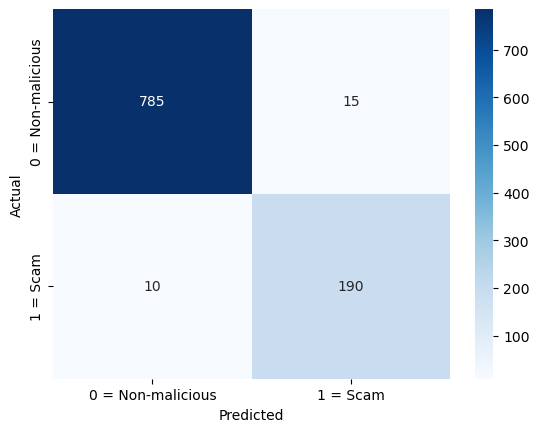

Precision : 92.68%
Recall : 95.00%
Number of OOV words skipped is 179


In [57]:
# Now to plot confusion matrix, show recall and precision
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Use sklearn to get confusion matrix values from predictor
conf_matrix = confusion_matrix(test_df['class'], pred)

# Plot using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0 = Non-malicious', '1 = Scam'], 
            yticklabels=['0 = Non-malicious', '1 = Scam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

print(f"Precision : {precision_score(test_df['class'], pred) * 100:.2f}%")
print(f"Recall : {recall_score(test_df['class'], pred) * 100:.2f}%")



# Part 2 Q2

print(f"Number of OOV words skipped is {sum(oov_count.values())}")
# Quite many words were skipped



In [58]:
# Part 2 Q3
from pprint import pprint
# First get predicted class probabilities for each instance
predicted_probs = model.predict_proba(test_data)
print(model.classes_)
print(predicted_probs[:10])

instance_probs = []  # First element is instance, second is prob of 0(nonscam), third is prob of 1(scam)
instance_confidence = [] # First element is instance, second is confidence for non-malicious, third for scam, fourth is original text
for i in range(len(predicted_probs)):
    instance = test_df['textPreprocessed'].loc[i]
    instance_probs.append([instance, *(predicted_probs[i].tolist())])
    real_text = test_df['textOriginal'].loc[i]
    
    # index 0 = prob of non scam, 1 = prob of scam, both given the test instance
    non_scam_confidence = predicted_probs[i][0] / predicted_probs[i][1]
    scam_confidence = predicted_probs[i][1] / predicted_probs[i][0]
    
    instance_confidence.append([instance, non_scam_confidence, scam_confidence, real_text])
    

# A : classified scam with high confidence -- element 3
print("Top 5 most confident to be scams as classified by model")
pprint([[f"REAL: {instance[3]}", f"PREP: {instance[0]}"] for instance in sorted(instance_confidence, key=lambda x: x[2], reverse=True)[:5]], compact=False, indent=2)

print("Top 5 most confident to be non-scams as classified by model")
# B : classified non-malicious with high confidence -- element 2
pprint([[f"REAL: {instance[3]}", f"PREP: {instance[0]}"] for instance in sorted(instance_confidence, key=lambda x: x[1], reverse=True)[:5]], compact=False, indent=2)

# C : on the boundary, R near 1.
bound_width = 0.25
print("Boundary instances")
for i in instance_confidence:
    # If R score for scam and nonscam are similar, theyre close to 1
    if abs(i[1] - i[2]) < bound_width:
        print(f"R-non-scam = {i[1]}, R-scam = {i[2]}")
        print(f"REAL: {i[3]}")
        print(f"PREP: {i[0]}")
        print()

[0 1]
[[9.99802906e-01 1.97094426e-04]
 [9.99999405e-01 5.94851453e-07]
 [9.99914145e-01 8.58549033e-05]
 [9.99999967e-01 3.30104973e-08]
 [3.27228433e-08 9.99999967e-01]
 [1.00000000e+00 6.62774452e-14]
 [8.54892539e-01 1.45107461e-01]
 [9.93768132e-01 6.23186845e-03]
 [9.99443233e-01 5.56766595e-04]
 [9.99999933e-01 6.71365781e-08]]
Top 5 most confident to be scams as classified by model
[ [ 'REAL: Urgent -call 09066649731from Landline. Your complimentary 4* Ibiza '
    'Holiday or £10,000 cash await collection SAE T&Cs PO BOX 434 SK3 8WP '
    '150ppm 18+',
    'PREP: . 4 + call £ - * holiday & urgent 18 t landline 150ppm cash cs '
    'await collection po box sae complimentary 10,000 ibiza'],
  [ 'REAL: Urgent! call 09066612661 from landline. Your complementary 4* '
    'Tenerife Holiday or £10,000 cash await collection SAE T&Cs PO Box 3 WA14 '
    '2PX 150ppm 18+ Sender: Hol Offer',
    'PREP: . 3 4 + ! call : £ offer * holiday & urgent 18 t landline 150ppm '
    'cash cs await co

## 3. Extending the model with semi-supervised training

## 4. Supervised model evaluation